<a href="https://colab.research.google.com/github/pathwaycom/pathway/blob/main/examples/notebooks/tutorials/alert-deduplication.ipynb" target="_parent"><img src="https://pathway.com/assets/colab-badge.svg" alt="Run In Colab" class="inline"/></a>

# Installing Pathway with Python 3.10+

In the cell below, we install Pathway into a Python 3.10+ Linux runtime.

> **If you are running in Google Colab, please run the colab notebook (Ctrl+F9)**, disregarding the 'not authored by Google' warning.
> 
> **The installation and loading time is less than 1 minute**.


In [ ]:
%%capture --no-display
!pip install --prefer-binary pathway

In [ ]:
import logging

logging.basicConfig(level=logging.CRITICAL)

# Smart real-time monitoring application with alert deduplication

In many monitoring environments, especially those dealing with complex systems, it's common for multiple alerts to be triggered for the same underlying issue. This creates the necessity for alert deduplication, with rules matching specific business needs. In this tutorial we will show how to design and implement such deduplication mechanism in Pathway handling real-time streaming data.

For the sake of this tutorial, let's assume we observe a simple stream of floating-point values and our business rule is to notify only whenever the maximal observed value is 30% larger than the previously alerted value.

## Sample data
Let's generate some static data, which we will convert to a stream later on:

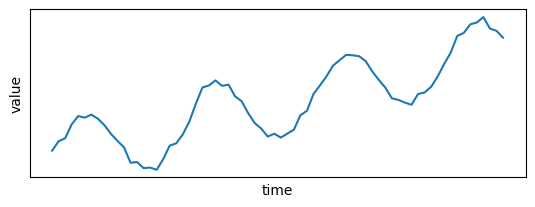

In [ ]:
# GENERATE AND PLOT SAMPLE DATA
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(10)
nb_points = 70

# Generate x values
x = np.linspace(0, nb_points - 1, nb_points).astype(int)

# Generate y values with a globally increasing trend and periodic pattern
trend = 0.3 * x**1.1  # Globally increasing trend
periodic_pattern = 10 * np.sin(2 * np.pi * x / 20)
noise = np.random.normal(0, 1, nb_points)

# Combine trend and periodic pattern to create y values
y = trend + periodic_pattern + noise


# PLOTTING
def set_params_plot():
    plt.xlabel("time")
    plt.ylabel("value")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title("")


# Plot the data points
plt.subplot(2, 1, 1)
set_params_plot()
plt.plot(x, y)

plt.show()

Great! The rule mentioned at the beginning should discover the peaks in this data. Let's see how to use Pathway to create an alerting application notifying us about these peaks.


We start by creating a stream out of the above data

In [ ]:
import pathway as pw

# To use advanced features with Pathway Scale, get your free license key from
# https://pathway.com/features and paste it below.
# To use Pathway Community, comment out the line below.
pw.set_license_key("demo-license-key-with-telemetry")


value_functions = {
    "time": lambda i: int(x[i]),
    "value": lambda i: float(y[i]),
}


class InputSchema(pw.Schema):
    time: int
    value: float


input = pw.demo.generate_custom_stream(
    value_functions,
    schema=InputSchema,
    nb_rows=len(x),
    input_rate=50,
    autocommit_duration_ms=10,
)

To track the maximum value, we could write `input.groupby().reduce(max=pw.reducers.max(input.value))`. Here we want to keep track also *when* this maximum occured, therefore we use the `argmax_rows` utility function.

In [ ]:
reduced = pw.utils.filtering.argmax_rows(input, what=input.value)

The newly defined `reduced` table will contain only at most a single row, which will be automatically updated by Pathway with a current maximum. This is not yet what we want - adding alerting callback listening for changes to the above table, would result in excessive notifications.


We would want to keep a state with the previous maximum value and see if the change is significant, e.g. if a new maximum is 30% larger than the previous one. Such rule can be expressed as a plain Python function returning `True` if we want to accept new maximum and somehow save it in the state


In [ ]:
def accept_larger_max(new_max: float, prev_max: float) -> bool:
    return (
        new_max > prev_max * 1.3
    )  # your custom business rule for deduplicating alerts

All you have to do now is to use the `pw.stateful.deduplicate` function to tell Pathway to use your newly defined rule. New values pushed by the stream to the `col` column will be compared to the previously accepted value using the `acceptor` function which we just wrote. Pathway will keep the needed state (i.e. previously accepted value) and perform all the necessary updates for you.

In [ ]:
result = pw.stateful.deduplicate(reduced, col=reduced.value, acceptor=accept_larger_max)

Now we can send the alerts to e.g. Slack. We can do it similarily as in the [realtime log monitoring tutorial](/developers/templates/realtime-log-monitoring#scenario-2-sending-the-alert-to-slack) by using `pw.io.subscribe`.

Here, for testing purposes, instead of sending an alert, we will store the accepted maxima in the list.

In [ ]:
alerts = []


def send_alert(key, row, time, is_addition):
    if is_addition:
        alerts.append(
            row
        )  # change here to send slack message instead of appending to a list

In [ ]:
pw.io.subscribe(result, send_alert)

Let's run the program. Since the stream we defined is bounded (and we set high `input_rate` in the `generate_custom_stream`), the call to `pw.run` will finish quickly. Hovever, in most usecases, you will be streaming data (e.g. from kafka) indefinitely.

In [ ]:
pw.run(monitoring_level=pw.MonitoringLevel.NONE)

Let's see the results and plot them on the dataset, to see what the alerts are:

In [ ]:
alerts

[{'time': 0, 'value': 1.331586504129518},
 {'time': 1, 'value': 4.1054489181478795},
 {'time': 3, 'value': 9.086296950451466},
 {'time': 6, 'value': 11.929292906576023},
 {'time': 23, 'value': 19.916221549411024},
 {'time': 43, 'value': 26.39125568534823},
 {'time': 62, 'value': 35.10960077729024}]

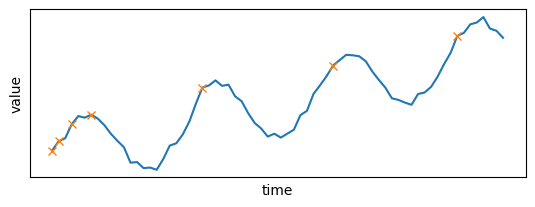

In [ ]:
# plot alerted points on top of the data
plt.subplot(2, 1, 1)
set_params_plot()
plt.plot(x, y)
plt.plot([r["time"] for r in alerts], [r["value"] for r in alerts], "x")
plt.show()

Great, we won't be overwhelmed with excessive notifications!
One downside is that initially we get some alerts, but this is how we defined our deduplication rule! It is easy to fix it by e.g. by considering maxima above a given threshold.

The presented deduplication functionality can be used in many other contexts - e.g. in transportation to filter GPS positions of devices so that we keep only relevant measurements which are sufficiently distant apart.